In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import scipy.stats as sc
#import shap
#import lime
import sklearn 
import warnings
#import xgboost

import multiprocessing as mp
import time
import pickle 
#import interpret
import collections
import math
import random
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import  RandomForestRegressor
from sklearn.svm import SVC, LinearSVC
from sklearn import preprocessing
#from interpret.glassbox import ExplainableBoostingClassifier
#from interpret import show
from sklearn.preprocessing import LabelEncoder
#from interpret.glassbox import ExplainableBoostingRegressor
#from interpret import show
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import AdaBoostRegressor
%matplotlib inline
import os, sys
#import statsmodels.api as sm
sys.path.append(os.path.abspath("../../../"))

pd.set_option('display.max_columns', None)
#import eli5
#from eli5.sklearn import PermutationImportance


# Load Test Data

In [2]:
titanic = pd.read_csv('train.csv')
#titanic
full_data = titanic
full_data = full_data.drop(['PassengerId'], axis=1)

import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
full_data['Cabin'] = full_data['Cabin'].fillna("U0")
full_data['Deck'] = full_data['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
full_data['Deck'] = full_data['Deck'].map(deck)
full_data['Deck'] = full_data['Deck'].fillna(0)
full_data['Deck'] = full_data['Deck'].astype(int)

full_data = full_data.drop('Cabin', axis = 1)

mean = full_data["Age"].mean()
std = full_data["Age"].std()
is_null = full_data["Age"].isnull().sum()
# compute random numbers between the mean, std and is_null
rand_age = np.random.randint(mean - std, mean + std, size = is_null)
# fill NaN values in Age column with random values generated
age_slice = full_data["Age"].copy()
age_slice[np.isnan(age_slice)] = rand_age
full_data["Age"] = age_slice
full_data["Age"] = full_data["Age"].astype(int)
full_data["Age"].isnull().sum()
full_data['Embarked'] = full_data['Embarked'].fillna('S')


full_data['Fare'] = full_data['Fare'].fillna(0)
full_data['Fare'] = full_data['Fare'].astype(int)
full_data = full_data.drop(['Name'], axis=1)
full_data = full_data.drop(['Ticket'], axis=1)
full_data['Sex'] = full_data['Sex'].map({"male": 0, "female": 1})


full_data_train,full_data_test = train_test_split(full_data,test_size = 0.3,random_state = 10)

full_data = pd.get_dummies(full_data,columns = ['Pclass','Embarked','Deck'])
full_data = full_data.dropna().reset_index().drop('index',axis = 1)
X = full_data.drop('Survived',axis = 1)
cols = X.columns
y = full_data['Survived']
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
X =pd.DataFrame(X, columns = cols)
xTrain, xTest, yTrain, yTest = train_test_split(X,y, test_size = 0.3,random_state = 10)


https://scikit-learn.org/dev/auto_examples/tree/plot_unveil_tree_structure.html

# Model

In [3]:
import itertools
import gc

In [4]:
def get_node_depths(tree1):
    def get_node_depths_(current_node, current_depth, l, r, depths):
        depths += [current_depth]
        if l[current_node] != -1 and r[current_node] != -1:
            get_node_depths_(l[current_node], current_depth + 1, l, r, depths)
            get_node_depths_(r[current_node], current_depth + 1, l, r, depths)

    depths = []
    get_node_depths_(0, 0, tree1.tree_.children_left, tree1.tree_.children_right, depths) 
    return np.array(depths)

def get_shared_nodes(i1,i2,node_indicator,n_nodes):
    sample_ids = [i1, i2]
    common_nodes = (node_indicator.toarray()[sample_ids].sum(axis=0) ==
                    len(sample_ids))
    
    common_node_id = np.arange(n_nodes)[common_nodes]
    
    return common_node_id

# Tree distance between nodes n1, n2 = depth(n1) + depth(n2) - 2 depth(LCA)
def distance_between_samples(indexes,depths,leaves,node_indicator,n_nodes):
    i1 = indexes[0]
    i2 = indexes[1]
    leaf_node1 = leaves[i1]
    leaf_node2 = leaves[i2]
    depth_node1 = depths[leaf_node1]
    depth_node2 = depths[leaf_node2]
    ancestors = get_shared_nodes(i1,i2,node_indicator,n_nodes)
    depth_LCA = max(depths[ancestors])
    
    dist = depth_node1 + depth_node2 - 2*depth_LCA
    if dist < 0:
        print(len(depths))
        depths[ancestors]
    return dist

In [5]:
# bootstraps data and builds a tree, then calculates pairwise distances on the data instances relative to the tree
# Tree distance is calculated via lowest common ancestor
def build_tree(xTrain,yTrain,xTest):
    train = xTrain.copy()
    train['y'] = yTrain
    train1 = train.sample(n = len(train), replace = True) 
    yTrain1 = train1['y']
    xTrain1 = train1.drop('y',axis = 1)
    gc.collect()
    estimator = DecisionTreeClassifier().fit(xTrain1,yTrain1)
    n_nodes = estimator.tree_.node_count
    depths = get_node_depths(estimator)
    leaves_train = estimator.apply(xTrain)
    leaves_test = estimator.apply(xTest)
    node_indicator_test = estimator.decision_path(xTest)
    node_indicator_train = estimator.decision_path(xTrain)
    train_comb = list(itertools.combinations(range(0,len(xTrain)), 2))
    test_comb = list(itertools.combinations(range(0,len(xTest)), 2))

    ### Train Distances
    train_distances = []
    for indexes in train_comb:
        dist = distance_between_samples(indexes,depths,leaves_train,node_indicator_train,n_nodes)
        train_distances.append([indexes[0],indexes[1],dist])

    ### Test Distances
    test_distances = []
    for indexes in test_comb:
        dist = distance_between_samples(indexes,depths,leaves_train,node_indicator_test,n_nodes)
        test_distances.append([indexes[0],indexes[1],dist])

    train_dist_df = pd.DataFrame(train_distances, columns = ['i1','i2','tree_dist'])
    test_dist_df = pd.DataFrame(test_distances, columns = ['i1','i2','tree_dist'])
    return([estimator,train_dist_df,test_dist_df])

In [6]:
def fit_random_forest(xTrain,yTrain,num_trees,xTest):
    i = 0
    mods = []
    train_dists = pd.DataFrame()
    test_dists = pd.DataFrame()
    while i <= num_trees:
        tree = build_tree(xTrain,yTrain,xTest)
        mods.append(tree[0])
        train_dists = train_dists.append(tree[1])
        test_dists = test_dists.append(tree[2])
        i = i+1
        
    train_final_dist = train_dists.groupby(['i1','i2']).mean().reset_index()
    test_final_dist = test_dists.groupby(['i1','i2']).mean().reset_index()
    return(mods,train_final_dist,test_final_dist)

def rf_predict(xTest,mods):
    pred = []
    for clf in mods:
        pred.append(clf.predict(xTest))
    pred = np.mean(pred,axis = 0)
    pred = [int(x) for x in pred>=0.5]
    return pred

In [7]:
def rf_predict(xTest,mods):
    pred = []
    for clf in mods:
        pred.append(clf.predict(xTest))
    pred = np.mean(pred,axis = 0)
    pred = [int(x) for x in pred>=0.5]
    return pred


In [11]:
mods,train_final_dist,test_final_dist = fit_random_forest(xTrain,yTrain,100,xTest)

225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225


225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225


225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225


225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
213


213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213


213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213


201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201


227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227


227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227


227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227


193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193


213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213


209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209


209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209


193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193


193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193


215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215


203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203


197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197
197


193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193


193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193


205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205


205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205


203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203


203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239


239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239


195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195


195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195


203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203


217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217


195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195


189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189


173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209


209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215


215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215


213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213


211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211


211
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231


213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213


213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217


217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217


217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217


221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221


207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207


225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225


161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161
161


221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221


199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199


215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215


215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215


217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217


217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217


231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231


219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219


217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217


189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189


225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225


225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209


213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213


219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219


215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215


187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187


187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187


207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207


189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189


221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221


221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221


211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211


211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211


201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201


211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211


219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219


219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205


205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205


213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213


209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209


209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
225
225
225
225
225
225


225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225


225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225


219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219


219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219


205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205


243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
243
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205


205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205
205


195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195


231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231


231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231
231


217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217


227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227


217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217


201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201


233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233


221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221
221


235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235


235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235


219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219


233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233


219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219


199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199
199


223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223
223


209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209


187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187
187


217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181
181


215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215


217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217
217


207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207


207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207
207


215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215


233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233
233


203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203


203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209


209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209


185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185


219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219


219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219


193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193
193


227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219


219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219
219


213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213


225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225


In [12]:
train_final_dist = train_final_dist.groupby(['i1','i2']).mean().reset_index()
test_final_dist = test_final_dist.groupby(['i1','i2']).mean().reset_index()

In [13]:
pred = rf_predict(xTest,mods)
print(np.mean(pred==yTest))

0.8059701492537313


In [14]:
#test_final_dist1

In [15]:
test_final_dist1 = test_final_dist.copy()
test_final_dist1['i1'] = test_final_dist['i2']
test_final_dist1['i2'] = test_final_dist['i1']
test_final_dist = test_final_dist.append(test_final_dist1)

In [16]:
dist = np.zeros(shape = (max(test_final_dist['i1'])+1,max(test_final_dist['i1'])+1))
for i in range(0,len(test_final_dist)):
    temp = test_final_dist.iloc[i]
    i1 = int(temp['i1'])
    i2 = int(temp['i2'])
    tree_dist = temp['tree_dist']
    dist[i1][i2] = tree_dist

In [17]:
dist

array([[ 0.        , -3.64356436, -1.55445545, ..., 11.45544554,
        12.31683168, 11.27722772],
       [-3.64356436,  0.        , -4.42574257, ..., 11.11881188,
        11.98019802, 10.94059406],
       [-1.55445545, -4.42574257,  0.        , ..., 15.02970297,
        15.89108911, 14.85148515],
       ...,
       [11.45544554, 11.11881188, 15.02970297, ...,  0.        ,
         4.44554455,  5.68316832],
       [12.31683168, 11.98019802, 15.89108911, ...,  4.44554455,
         0.        ,  4.58415842],
       [11.27722772, 10.94059406, 14.85148515, ...,  5.68316832,
         4.58415842,  0.        ]])

In [18]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters = 3).fit(dist)

In [19]:
xTest['clust'] = clustering.labels_

/Users/aparnacalambur/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
clusters = pd.DataFrame(np.column_stack((yTest,clustering.labels_)),columns = ['y','clust'])

In [21]:
clusters.groupby('clust').mean()

,y
clust,
0,0.122302
1,0.738636
2,0.292683


In [22]:
full_data_test['clust'] = clustering.labels_
clusters = np.unique(clustering.labels_)
clusters

array([0, 1, 2])

0.1223021582733813
0.7386363636363636
0.2926829268292683


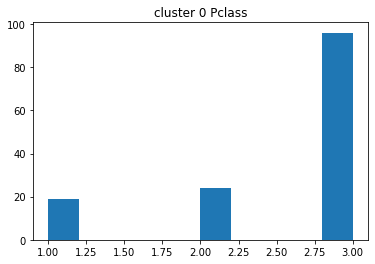

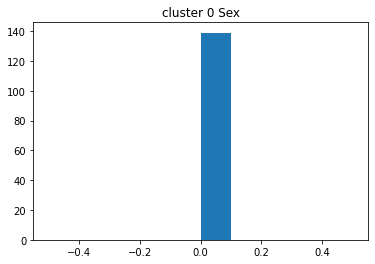

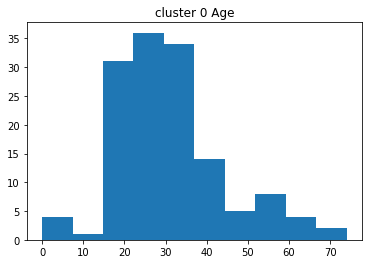

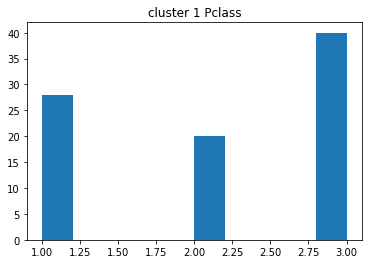

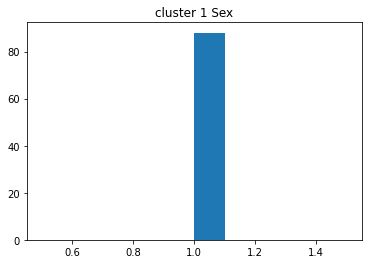

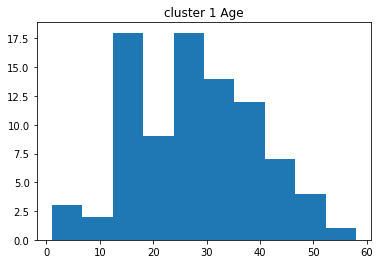

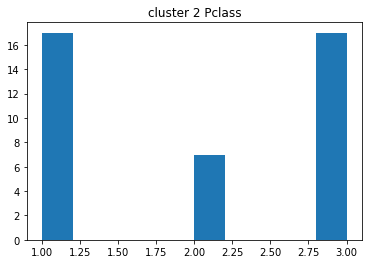

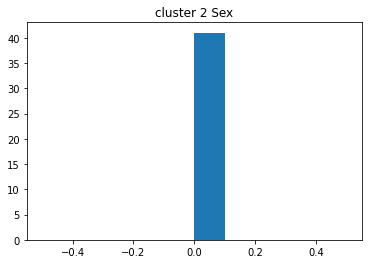

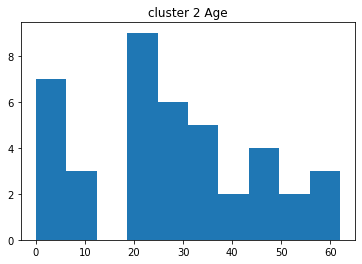

In [23]:
for clust in clusters:
    temp = full_data_test[full_data_test['clust']==clust]
    print(np.mean(temp['Survived']))
    plt.figure()
    plt.title('cluster '+str(clust)+ ' Pclass')
    plt.hist(temp['Pclass'])
    plt.figure()
    plt.title('cluster '+str(clust)+ ' Sex')
    plt.hist(temp['Sex'])
    plt.figure()
    plt.title('cluster '+str(clust)+ ' Age')
    plt.hist(temp['Age'])

In [24]:
full_data_test['clust'] = clustering.labels_
full_data_test[full_data_test['clust']==3]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,clust


In [25]:
(test_final_dist)

,i1,i2,tree_dist
0,0,1,-3.643564
1,0,2,-1.554455
2,0,3,10.277228
3,0,4,10.366337
4,0,5,-1.782178
...,...,...,...
35773,266,264,13.198020
35774,267,264,12.495050
35775,266,265,4.445545
35776,267,265,5.683168


In [26]:
full_data_test

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,clust
590,0,3,0,35,0,0,7,S,8,0
131,0,3,0,20,0,0,7,S,8,0
628,0,3,0,26,0,0,7,S,8,0
195,1,1,1,58,0,0,146,C,2,1
230,1,1,1,35,1,0,83,S,3,1
...,...,...,...,...,...,...,...,...,...,...
318,1,1,1,31,0,2,164,S,3,1
863,0,3,1,21,8,2,69,S,8,1
254,0,3,1,41,0,2,20,S,8,1
396,0,3,1,31,0,0,7,S,8,1


In [27]:
test_final_dist.to_csv("test_final_dist.csv")
full_data_test.to_csv("full_data_test.csv")